In [58]:
!pip install segment_anything
!pip install transformers datasets
!pip install monai
!pip install obspy

In [59]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/projects/DAS_ext/das_veh')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
import warnings
warnings.filterwarnings('ignore')

import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.ndimage import binary_dilation

# from download_data import load_data_from_zenodo
from modules.imaging_IO import ImagingIO
from modules.utils import Dispersion, plot_xcorr
from apis.timeLapseImaging import TimeLapseImaging
from apis.dispersion_classes import SurfaceWaveDispersion
from apis.virtual_shot_gather import construct_shot_gather,construct_shot_gather_other_side
from apis.imaging_workflow import ImagingWorkflowOneDirectory

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import SamModel, SamProcessor
import datasets

from typing import List, Dict, Any
import cv2

import pickle
from PIL import Image
# from torch.utils.data import Dataset, Dataloader

from torch.optim import Adam
import monai

import random

In [61]:
# FROM https://github.com/syyuan93/das_veh/tree/main

# Peak parameters for vehicle tracking algorithm
tracking_args = {
    "detect":{
            "minprominence": 0.2,
            "minseparation": 30,
            "prominenceWindow": 600,
    }
}

# Define the name of the root directory containing subsurface imaging datasets
_root = 'subsurface_imaging_dataset/'
# Specify the directory corresponding to the date of the dataset
date_dir = '20221223'
# Initialize an ImagingIO object.
# 'io' serves as an iterable object where io[idx] returns a 10-minute time window with index, idx.
# The 'directory' parameter points to the specific date directory, and 'root' points to the root directory.
# 'ch1' and 'ch2' represent channel ranges for imaging.
io = ImagingIO(directory=date_dir,root=_root, ch1=400, ch2=600)

In [63]:
# FROM https://github.com/syyuan93/das_veh/tree/main

def resample(input, x_axis, t_axis, subsamp_factor=5, channel0=400):
    # Convert from 250 sampling rate to 50
    input = input[:, ::subsamp_factor]
    # Spatial interpolation from 8.16 m to 1 m
    input = scipy.signal.resample_poly(input, 204, 25)
    resampled_x_axis = np.arange(input.shape[0]) + (x_axis[0] - channel0) * 8.16
    resampled_t_axis = t_axis[::subsamp_factor]
    return input, resampled_x_axis, resampled_t_axis

In [62]:
# def bbox_to_window(input, bbox, x_axis, t_axis, subsamp_factor=5, channel0=400, mask=False, window=False):
#     if mask == True:
#         input = binary_dilation(input, iterations=2)  # Adjust iterations as needed
#     else:
#         # Convert from 250 sampling rate to 50
#         input = input[:, ::subsamp_factor]
#         # Spatial interpolation from 8.16 m to 1 m
#         input = scipy.signal.resample_poly(input, 204, 25)
#     resampled_x_axis = np.arange(input.shape[0]) + (x_axis[0] - channel0) * 8.16
#     resampled_t_axis = t_axis[::subsamp_factor]
#     # May need to add perturbation
#     [[xmin, ymin], [xmax, ymax]] = bbox
#     c1, c2, t1, t2 = np.argmin(np.abs(xmin-resampled_x_axis)), np.argmin(np.abs(resampled_x_axis-xmax)), np.argmin(np.abs(resampled_t_axis-ymin)), np.argmin(np.abs(resampled_t_axis-ymax))
#     window = input[c1:c2, t1:t2]

#     return window

In [64]:
def prepare_data(io, save_dir=False):
    _x0 = 640
    tracking_offset = 150
    _start_x = _x0 - tracking_offset
    _end_x = _x0 + tracking_offset
    tot_masks, tot_images, tot_bboxes = [], [], []
    for i, (data, x_axis, t_axis) in enumerate(io):

      # Track vehicle according to https://github.com/syyuan93/das_veh/tree/main
      imagingObj = TimeLapseImaging(data, x_axis, t_axis, method='xcorr')
      imagingObj.track_cars(start_x=_start_x, end_x=_end_x, show_plot=False, tracking_args=tracking_args)
      imagingObj.select_surface_wave_windows(x0=_x0, wlen_sw=22, length_sw=500, spatial_ratio=0.5, temporal_spacing=25)
      bboxes, binary = imagingObj.visualize_tracking(plt_tlim=500, t_min=70, plt_xlim=1000, ax=None, mask=True)
      mask = binary_dilation(binary, iterations=2)
      # Resample data for bbox extraction
      resampled_data, _, _ = resample(data, x_axis, t_axis)

      # Append masks, bboxes, resampled data
      tot_masks.append(mask)
      tot_bboxes.append(bboxes)
      tot_images.append(resampled_data)

    # Save to disk instead of keeping in RAM (avoid overflow)
    if save_dir:
      os.makedirs(save_dir, exist_ok=True)
      torch.save(torch.tensor(mask, dtype=torch.float32), os.path.join(save_dir, f"masks_sam.pt"))
      torch.save(torch.tensor(resampled_data, dtype=torch.float32), os.path.join(save_dir, f"images_sam.pt"))
      torch.save(torch.tensor(bboxes, dtype=torch.float32), os.path.join(save_dir, f"bboxes_sam.pt"))

    return tot_masks, tot_images, tot_bboxes

In [66]:
def pad(input, dims=(1024, 1024)):
  channels, time = input.shape
  cdim, tdim = dims
  cdiff, tdiff = cdim - channels, tdim - time
  cpad = (cdiff // 2, cdiff - cdiff // 2)
  tpad = (tdiff // 2, tdiff - tdiff // 2)
  padded = np.pad(input, [cpad, tpad], mode='constant')
  return padded

In [67]:
# def pad_resize(input, dim=(1024, 1024)):
#     channels, time = input.shape  # Current size = 68x1250
#     cdim, tdim = dim

#     # Resize height first to 1024
#     scale_factor = tdim / time
#     new_tdim = int(time * scale_factor)

#     resized = cv2.resize(input, (new_tdim, cdim), interpolation=cv2.INTER_LINEAR)

#     # Pad width to 1024
#     pad_left = (tdim - new_tdim) // 2
#     pad_right = tdim - new_tdim - pad_left

#     padded = np.pad(resized, [(0, 0), (pad_left, pad_right)], mode='constant', constant_values=0)
#     return padded

In [68]:
def patchify(data, mask=None, dim=(256, 256)):
  channels, time = data.shape
  data_patches, mask_patches = [], []
  cdim, tdim = dim
  c_sdim, t_sdim = dim

  for t in range(0, time -  tdim + 1, t_sdim):
    for c in range(0, channels - cdim + 1, c_sdim):
      # Make square patches of size dim
      data_patch = data[c:c+cdim, t:t+tdim].astype(float)
      mask_patch = mask[c:c+cdim, t:t+tdim].astype(float)
      # If less than 15% of pixels are masks, discard
      if mask_patch.sum() == 0 or (mask_patch.sum()/256*256) <= 0.15:
        continue
      else:
        # Normalize pixel values for SAM model
        data_norm, mask_norm = cv2.normalize(data_patch, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8), cv2.normalize(mask_patch, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        data_patches.append(data_norm)
        mask_patches.append(mask_norm)
  return data_patches, mask_patches

In [105]:
def get_bbox(mask):
  channels, time = mask.shape[0], mask.shape[1]
  # Checking first channel since all are the same
  y_idx, x_idx = np.where(mask[:, :, 0] > 0)
  ymin, xmin = np.min(y_idx), np.min(x_idx)
  ymax, xmax = np.max(y_idx), np.max(x_idx)

  xmin = max(0, xmin - np.random.randint(0, 20))
  xmax = min(channels, xmax + np.random.randint(0, 20))
  ymin = max(0, ymin - np.random.randint(0, 20))
  ymax = min(time, ymax + np.random.randint(0, 20))
  bbox = [xmin, ymin, xmax, ymax]

  return bbox

In [70]:
# FROM https://colab.research.google.com/drive/1Jb422MehJ6TYUCfcy6yxuSOJkSGAfJXj#scrollTo=HD_gWqamK_AA

def build_totalmask(pred: List[Dict[str, Any]]) -> np.ndarray:
  """Builds a total mask from a list of segmentations
  ARGS:
      pred (list): list of dicts with keys 'segmentation' and others
  RETURNS:
      total_mask (np.ndarray): total mask

  """

  total_mask = np.zeros(pred[0]['segmentation'].shape, dtype=np.uint8)
  for seg in pred:
      total_mask += seg['segmentation']
  # use cv2 to make image black and white
  _, total_mask = cv2.threshold(total_mask, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

  return total_mask

In [71]:
def unpad(input, dims=(68, 1250)):
  channels, time = input.shape
  cdim, tdim = dims
  if tdim > time:
    cdiff = channels - cdim
    cpad = cdiff // 2
    unpadded = input[cpad:cpad+cdim, :]
  else:
    cdiff, tdiff = channels - cdim, time - tdim
    cpad = cdiff // 2
    tpad = tdiff // 2
    unpadded = input[cpad:cpad+cdim, tpad:tpad+tdim]
  return unpadded

In [72]:
def unpad_resize(input, original_dims=(68, 1250)):
  current_channels, current_time = input.shape
  target_channels, target_time = original_dims

  # Calculate how much padding was added
  time_diff = current_time - (target_time * current_channels / target_channels)
  pad_left = int(time_diff // 2)
  unpadded = input[:, pad_left:current_time-pad_left]

  # Resize back to original dimensions
  unresized = cv2.resize(unpadded, (target_time, target_channels), interpolation=cv2.INTER_LINEAR)

  return unresized

In [89]:
# Load the model
model = SamModel.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
# Make sure we only mask decoder is being finetuned
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [90]:
# with open('tot_data_patches_256.pkl', 'rb') as f:
#   tot_data_patches = pickle.load(f)

# with open('tot_mask_patches_256.pkl', 'rb') as f:
#    tot_mask_patches = pickle.load(f)

In [91]:
# train, test = int(len(tot_data_patches)*0.8), int(len(tot_data_patches)*0.2)

In [92]:
# train_dataset_dict = {
#     "image": [Image.fromarray(np.stack([patch]*3, axis=2).astype(np.uint8)) for image in tot_data_patches[:train] for patch in image],
#     "label": [Image.fromarray(np.stack([patch]*3, axis=2).astype(np.uint8)) for mask in tot_mask_patches[:train] for patch in mask],
# }

# test_dataset_dict = {
#     "image": [Image.fromarray(np.stack([patch]*3, axis=2).astype(np.uint8)) for image in tot_data_patches[train:train+test] for patch in image],
#     "label": [Image.fromarray(np.stack([patch]*3, axis=2).astype(np.uint8)) for mask in tot_mask_patches[train:train+test] for patch in mask],
# }


# # del tot_data_patches, tot_mask_patches

# train_dataset = datasets.Dataset.from_dict(train_dataset_dict)
# test_dataset = datasets.Dataset.from_dict(test_dataset_dict)

In [93]:
def idx_filter(dataset, idx):
  return idx not in FT_idxs

In [94]:
# ft_dict = test_dataset[FT_idxs]
# ft_dict['label'] = new_masks
# ft_dataset = datasets.Dataset.from_dict(ft_dict)
# ft_SAM_dataset = SAMDataset(dataset=ft_dataset, processor=processor)
# ft_SAM_dataloader = DataLoader(ft_SAM_dataset, batch_size=2, shuffle=True, drop_last=False)

In [139]:
test_dataset = test_dataset.filter(idx_filter, with_indices=True)

Filter:   0%|          | 0/227 [00:00<?, ? examples/s]

In [96]:
# train_SAM_dataset = SAMDataset(dataset=train_dataset, processor=processor)
# test_SAM_dataset = SAMDataset(dataset=test_dataset, processor=processor)
# train_dataloader = DataLoader(train_SAM_dataset, batch_size=2, shuffle=True, drop_last=False)
# test_dataloader = DataLoader(test_SAM_dataset, batch_size=2, shuffle=True, drop_last=False)

In [130]:
# ADAPTED FROM https://github.com/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])
    if ground_truth_mask.ndim != 3:
      ground_truth_mask = np.stack([ground_truth_mask]*3, axis=2).astype(np.uint8)

    # Get bounding box prompt from ground truth mask
    prompt = get_bbox(ground_truth_mask)

    # Prepare image + bbox prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # Remove batch dimension added by processor
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # Add ground truth segmentation to input dict
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [131]:
with open('ft_SAM_dataloader.pkl', 'rb') as f:
  ft_SAM_dataloader = pickle.load(f)

with open('train_SAM_dataloader.pkl', 'rb') as f:
  train_dataloader = pickle.load(f)

with open('test_SAM_dataloader.pkl', 'rb') as f:
  test_dataloader = pickle.load(f)

In [132]:
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [133]:
# Uncomment if loading pre-trained model

# PATH = "selected_20e_256ft_SAM.pth"
# model.load_state_dict(torch.load(PATH, weights_only=True))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [134]:
epochs = 20

model.train()

for epoch in range(epochs):
  epoch_losses = []
  for batch in ft_SAM_dataloader:
    # Forward pass
    outputs = model(pixel_values=batch["pixel_values"].to(device),
                    input_boxes=batch["input_boxes"].to(device),
                    multimask_output=True)

    # Compute segmentation maskloss
    predicted_masks = outputs.pred_masks.squeeze(1).permute(0, 2, 3, 1)
    ground_truth_masks = batch["ground_truth_mask"].float().to(device)
    loss = seg_loss(predicted_masks, ground_truth_masks)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Optimization step
    optimizer.step()
    epoch_losses.append(loss.item())

  # Print results after each epoch
  print(f'EPOCH: {epoch}')
  print(f'Mean loss: {np.mean(epoch_losses)}')

EPOCH: 0
Mean loss: 68.08614017117408
EPOCH: 1
Mean loss: 52.169456728043095
EPOCH: 2
Mean loss: 49.623722999326645
EPOCH: 3
Mean loss: 48.67903297178207
EPOCH: 4
Mean loss: 48.105543751870435
EPOCH: 5
Mean loss: 47.57395085980815
EPOCH: 6
Mean loss: 47.183027944257184
EPOCH: 7
Mean loss: 46.817804705712106
EPOCH: 8
Mean loss: 46.44675377876528
EPOCH: 9
Mean loss: 46.18121737818564
EPOCH: 10
Mean loss: 45.953566397390055
EPOCH: 11
Mean loss: 45.68338209582913
EPOCH: 12
Mean loss: 45.44342705511278
EPOCH: 13
Mean loss: 45.2423031099381
EPOCH: 14
Mean loss: 45.11937645942934
EPOCH: 15
Mean loss: 44.927407849219534
EPOCH: 16
Mean loss: 44.80855061930995
EPOCH: 17
Mean loss: 44.69961763197376
EPOCH: 18
Mean loss: 44.610277298958074
EPOCH: 19
Mean loss: 44.44895104439028


In [135]:
PATH = "selected_20e_256ft_SAM.pth"
torch.save(model.state_dict(), PATH)

In [44]:
FT_idxs = [0, 3, 6, 18, 19, 23, 25, 37, 38, 41, 54, 57, 59, 65, 68, 74, 77, 83, 88, 89, 96, 99, 100, \
       104, 111, 113, 115, 117, 118, 119, 120, 121, 124, 139, 141, 142, 143, 145, 163, 175, 176, 196, 211,\
       213, 216, 220, 229, 237, 242, 270, 277, 281, 283, 285, 288, 295, 300, 305, 311, 319, 325, 327]

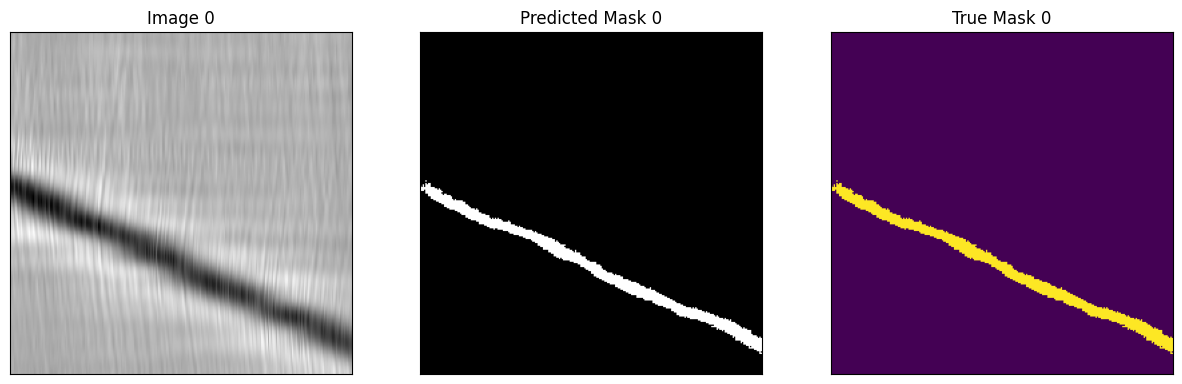

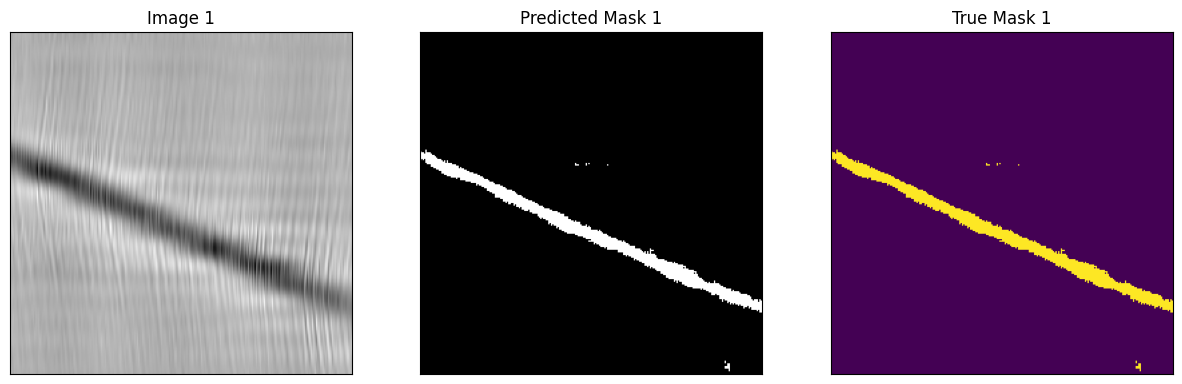

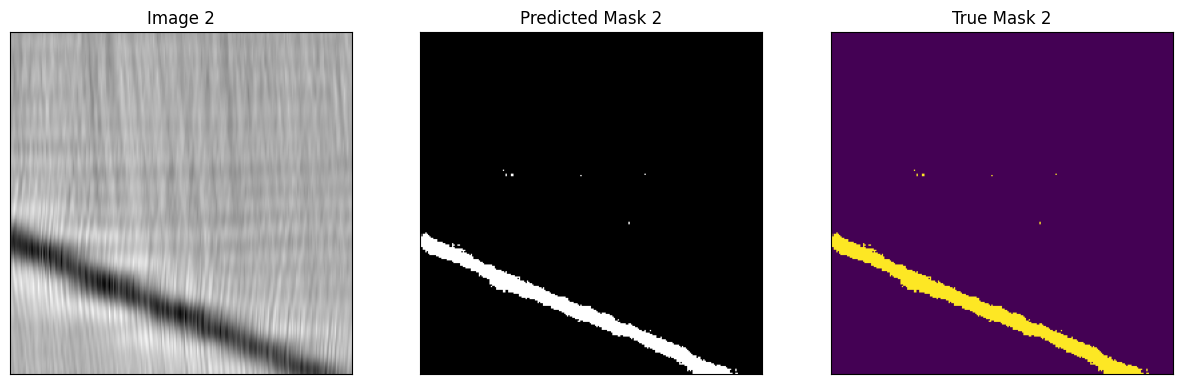

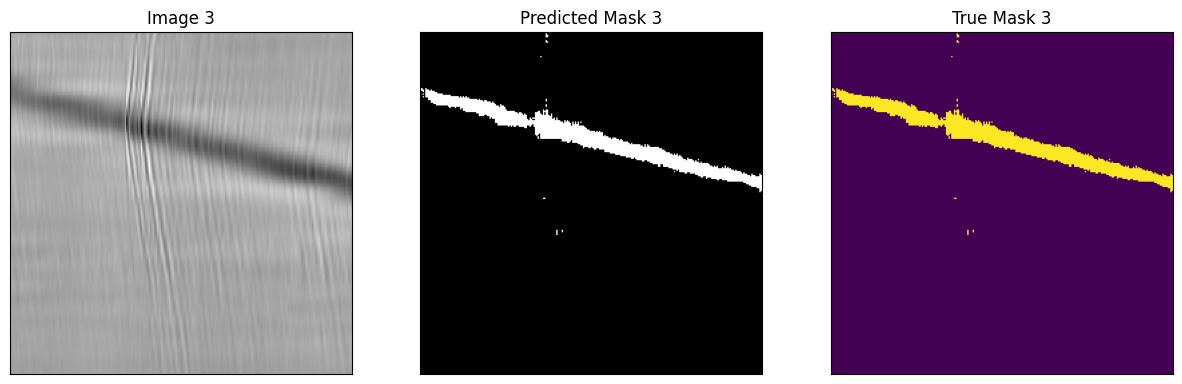

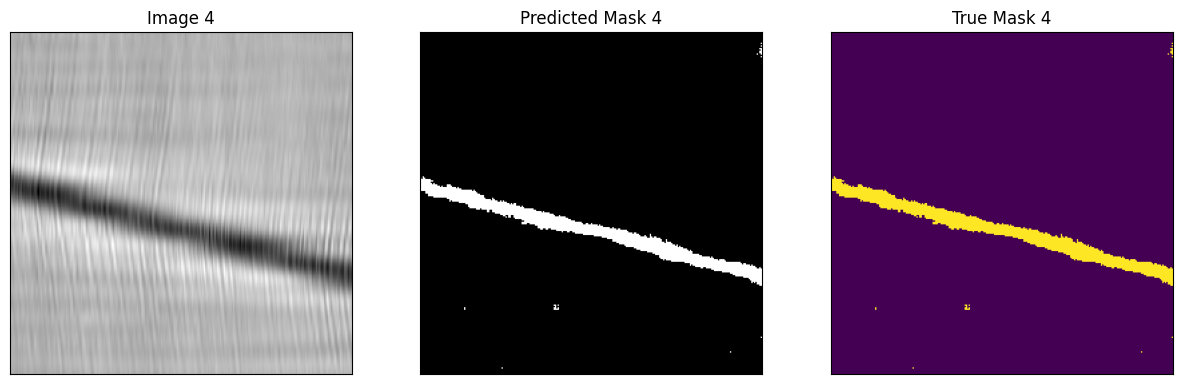

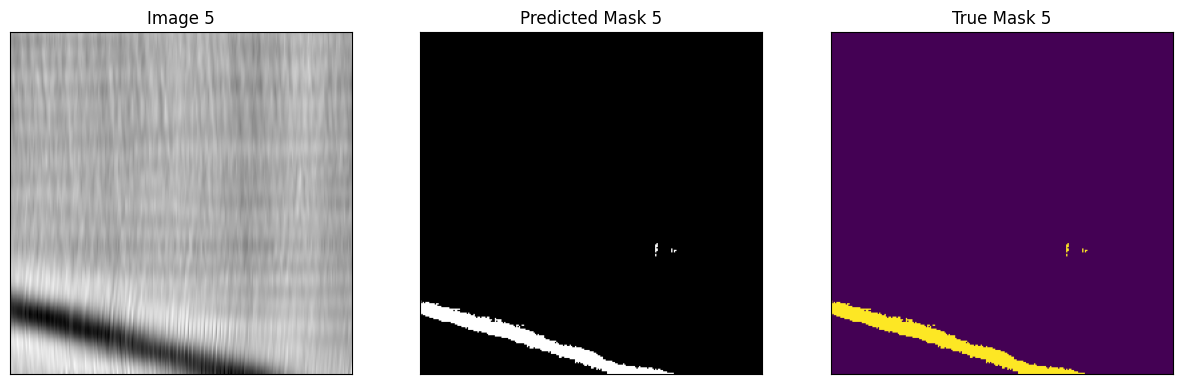

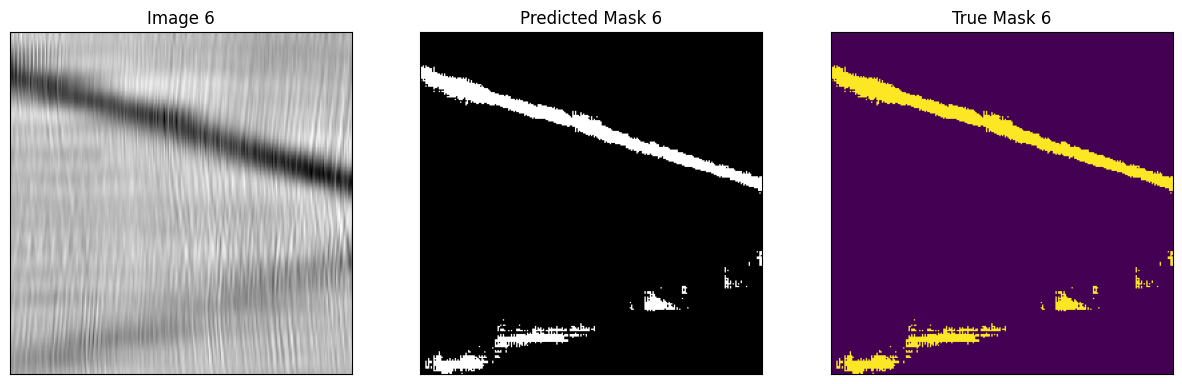

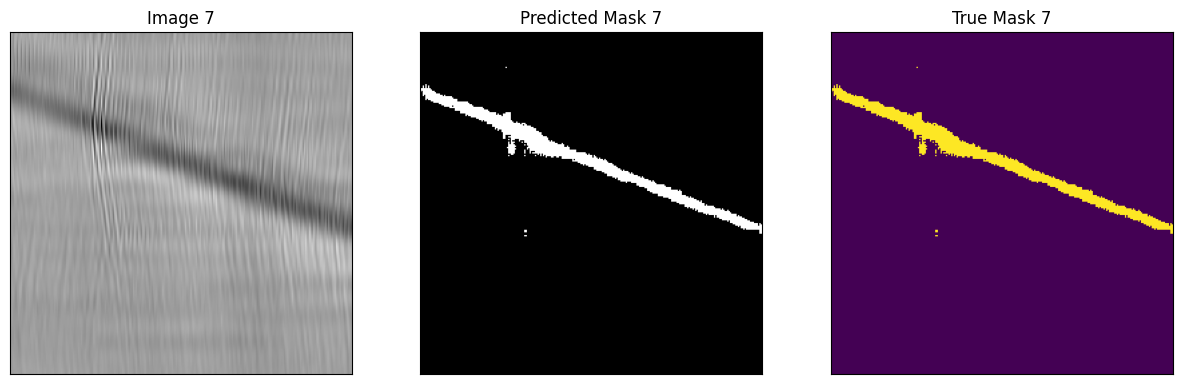

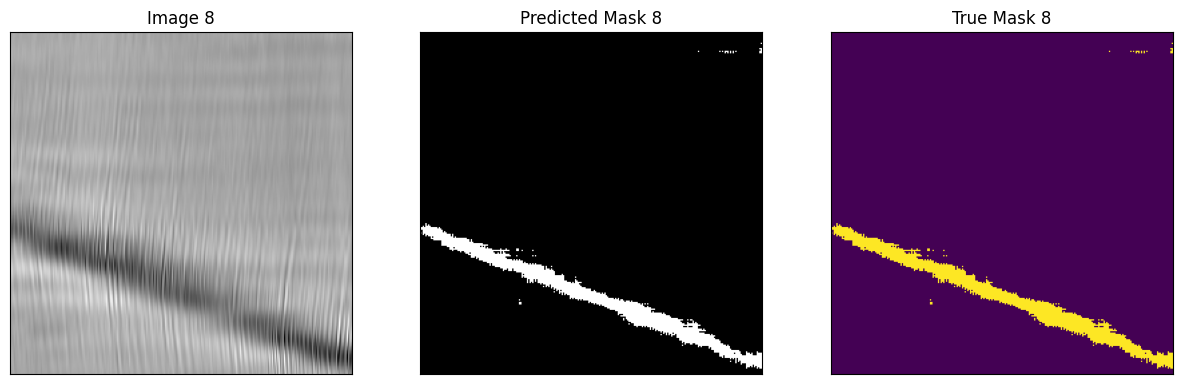

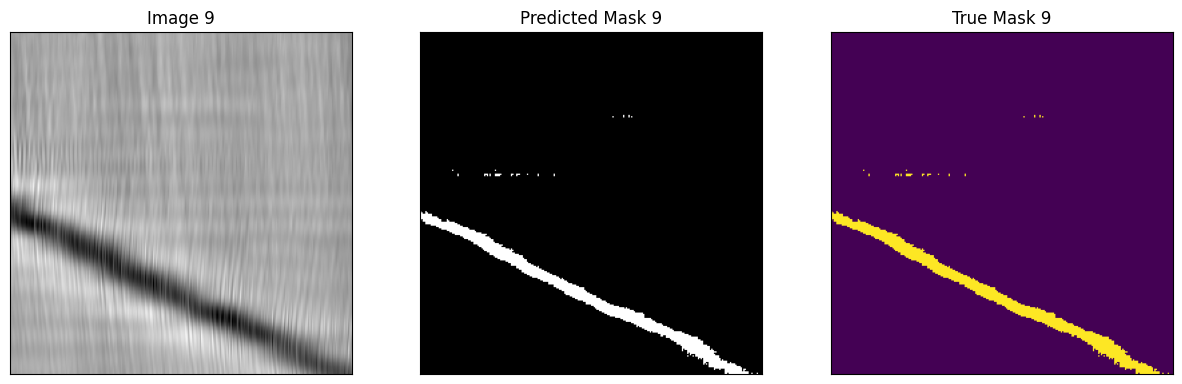

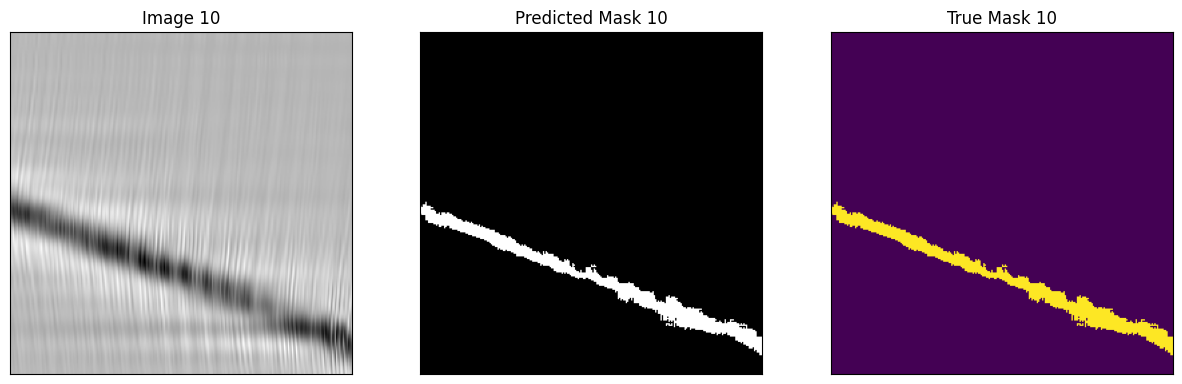

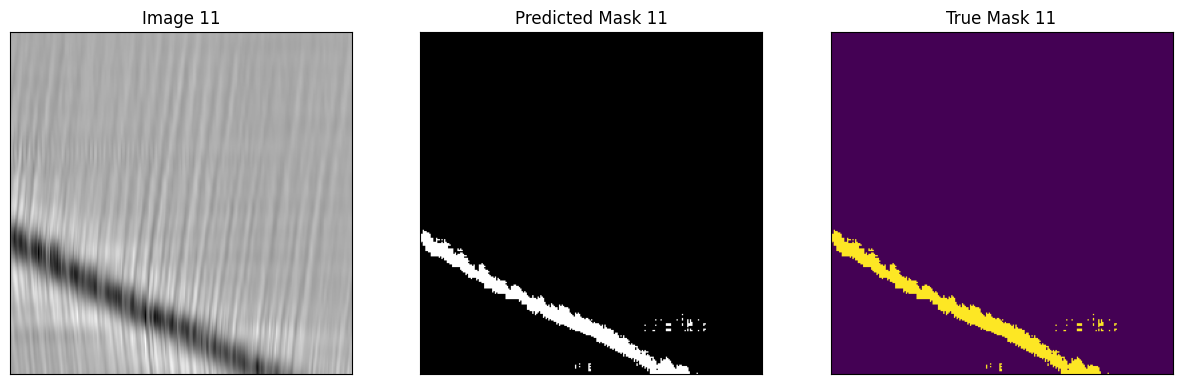

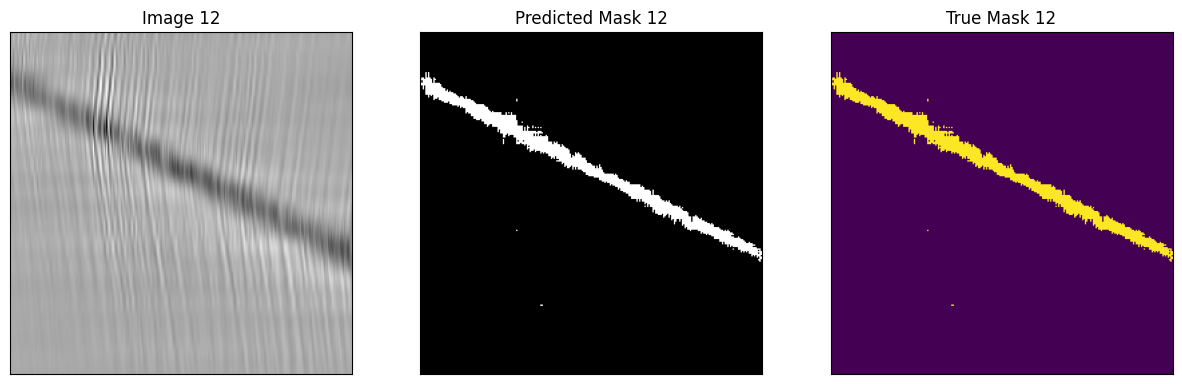

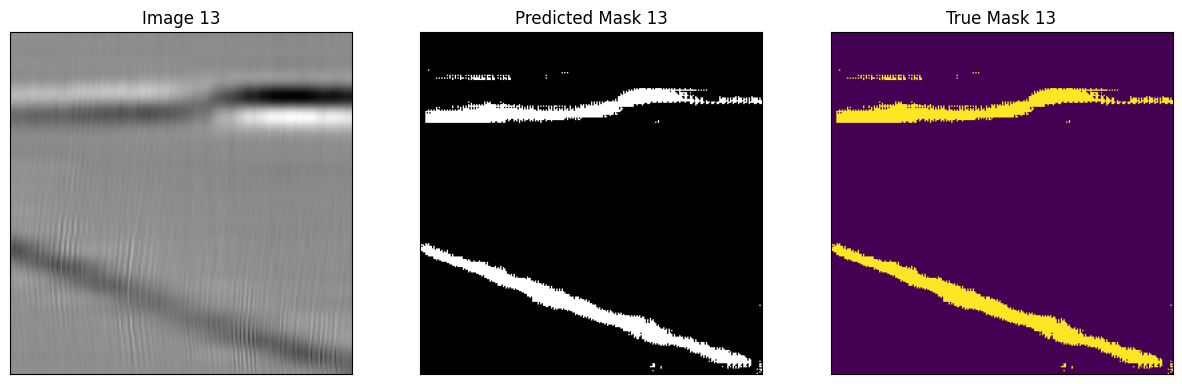

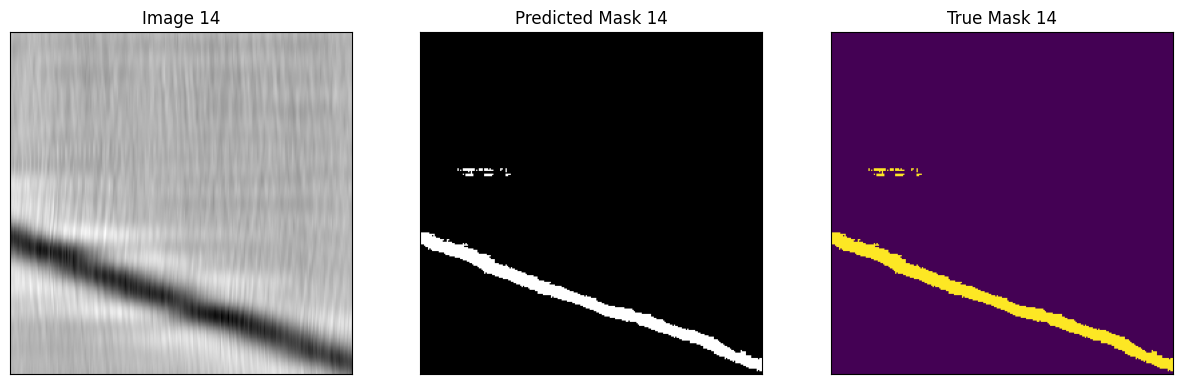

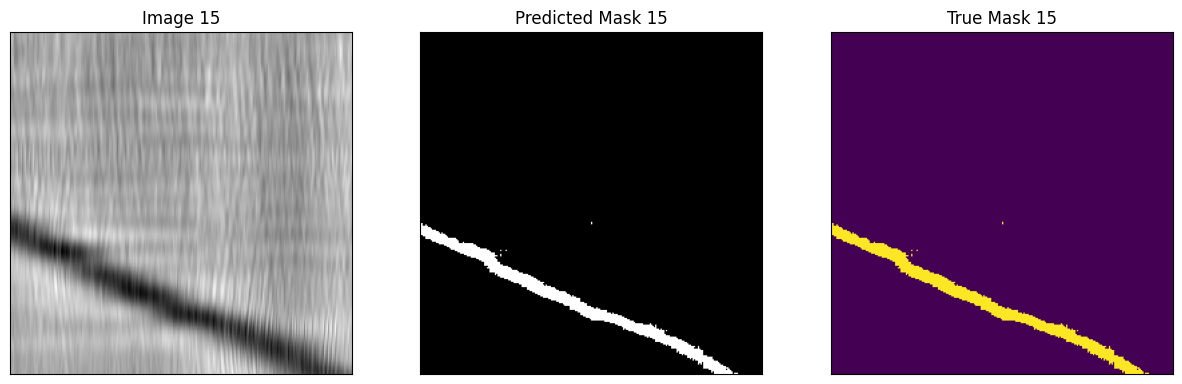

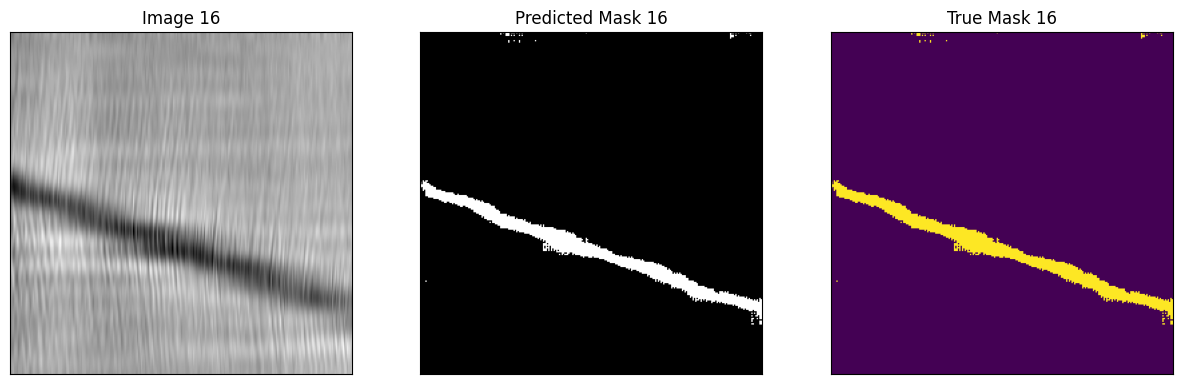

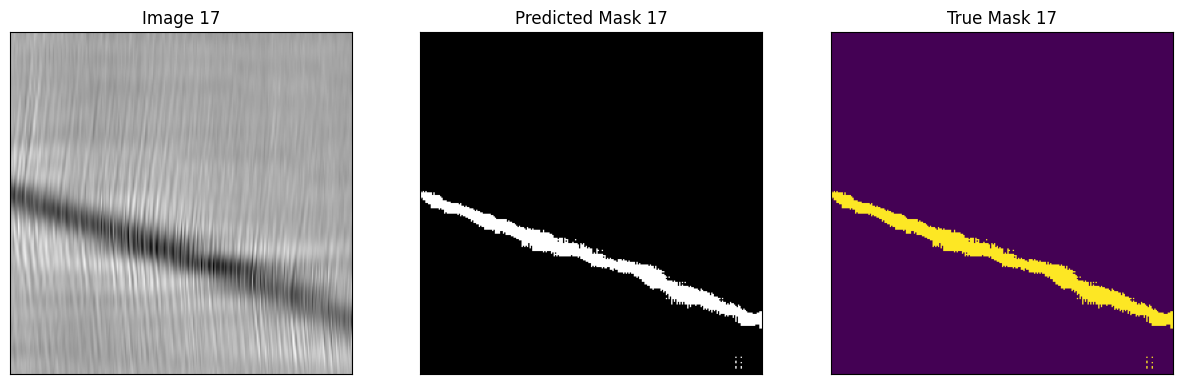

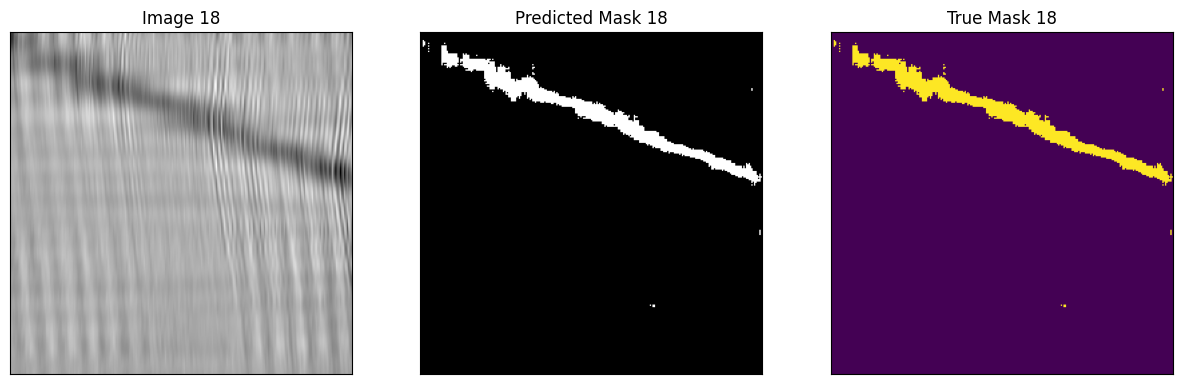

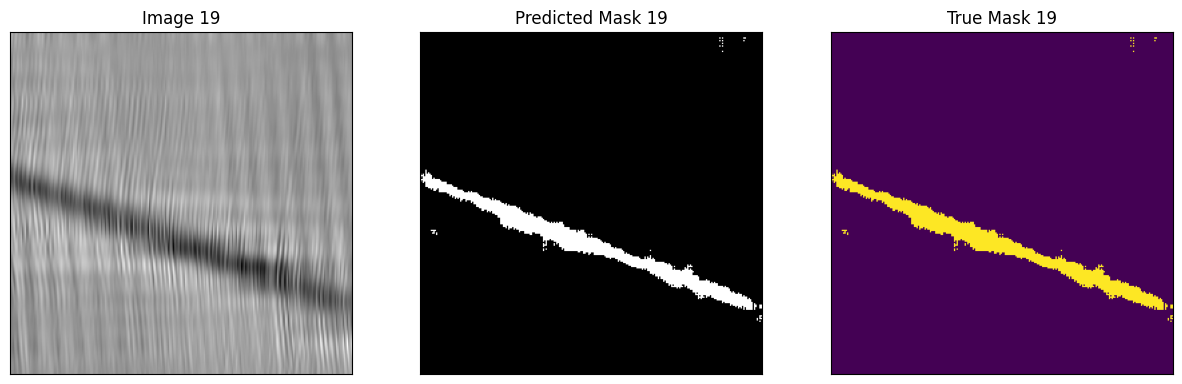

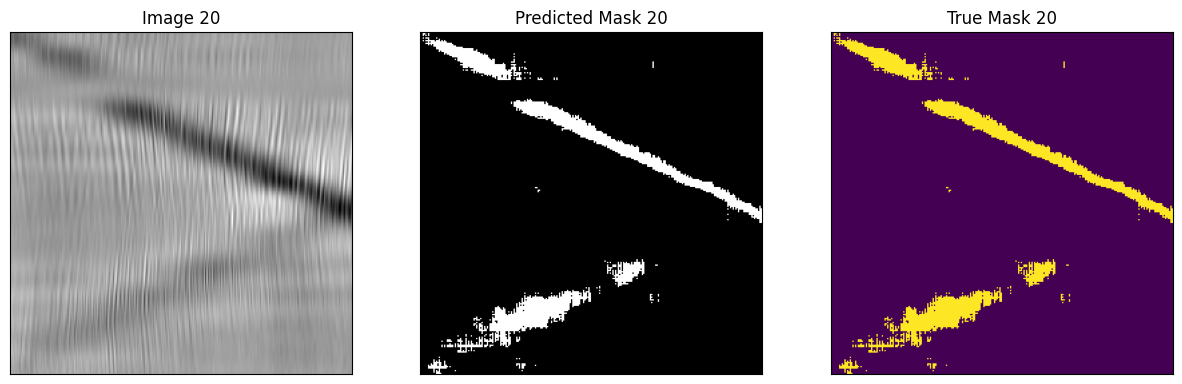

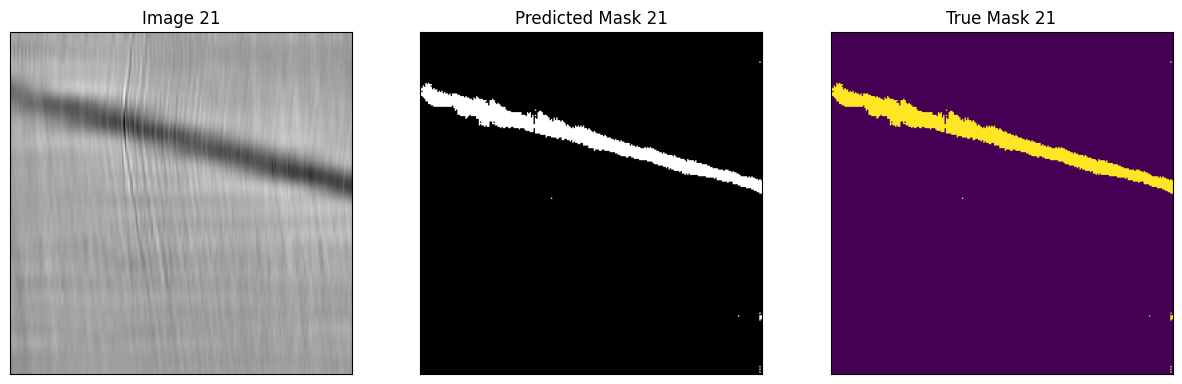

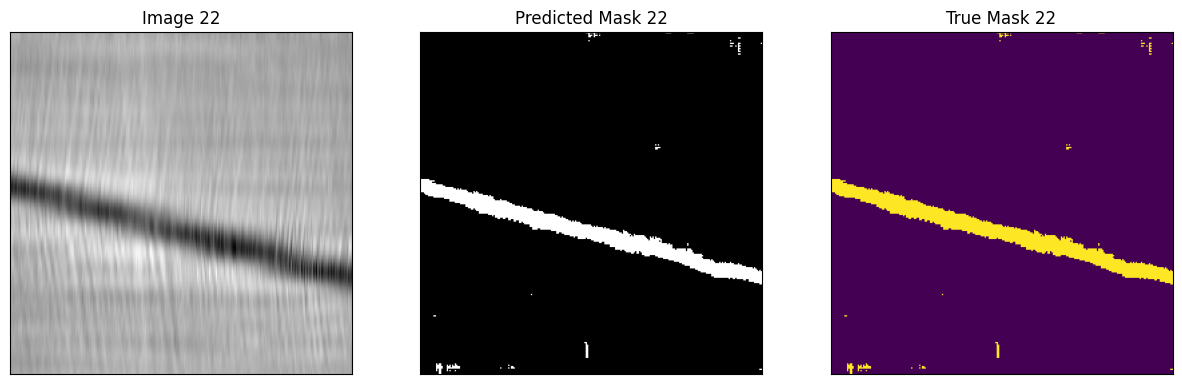

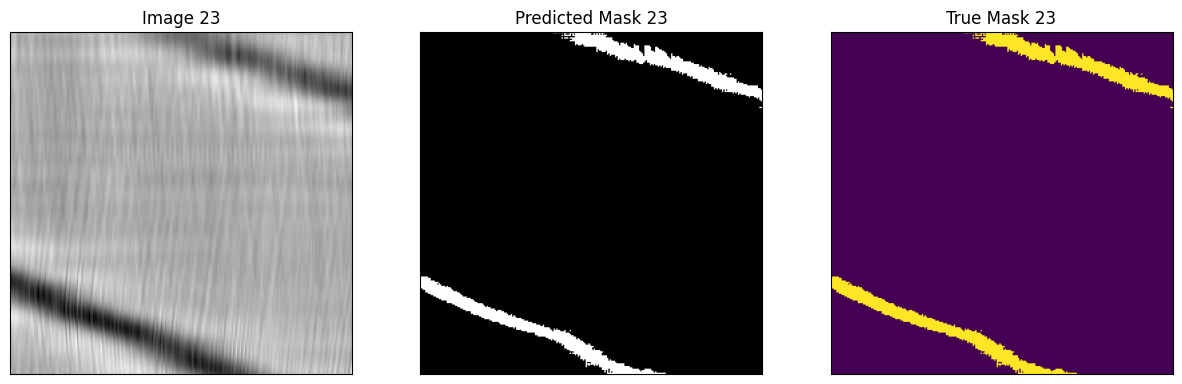

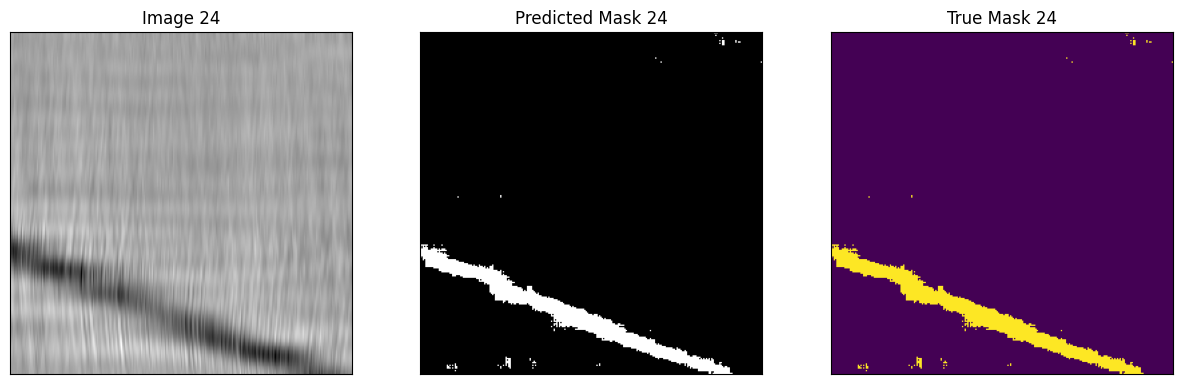

KeyboardInterrupt: 

In [53]:
# ADAPTED FROM https://github.com/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb

# Load images
new_masks = []
for idx in range(len(test_dataset)):
  test_image = test_dataset[idx]["image"]
  mask_image = test_dataset[idx]["label"]

  # Full bbox to promote model segmentation of all objects
  prompt = [0, 0, 256, 256]

  # Prepare image + bbox prompt for the model
  inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

  # Move the input tensor to the GPU
  inputs = {k: v.to(device) for k, v in inputs.items()}

  model.eval()

  # Forward pass
  with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

  # Apply sigmoid to get probabilities
  seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
  # convert soft mask to hard mask
  seg_prob = seg_prob.cpu().numpy().squeeze()
  final_seg = (seg_prob > 0.5).astype(np.uint8)

  new_masks.append(final_seg)

  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  # Plot input image
  axes[0].imshow(np.array(test_image), cmap='gray')
  axes[0].set_title(f"Image {idx}")

  # Plot predicted segmentation mask
  axes[1].imshow(final_seg, cmap='gray')
  axes[1].set_title(f"Predicted Mask {idx}")

  # Plot the ground truth mask
  axes[2].imshow(mask_image, cmap='gray')
  axes[2].set_title(f"True Mask {idx}")

  # Hide axis ticks and labels
  for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

  # Display the images side by side
  plt.show()